In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt

2.4.1


In [21]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [22]:
# paper's fully connected model learned on a subset of MNIST (n = 4000, d = 784, K = 10 classes)
x_train, y_train = x_train[:4000], y_train[:4000]
x_test, y_test = x_test[:4000], y_test[:4000]

Number of parameters = 3000, 3 hidden layer neurons
tf.Tensor(
[[275   0   0  13   3  64   2   1   4   8]
 [  0 402   8   3   8   1   8   4  10   6]
 [  1  28 275  49   2   5  10  11  34   3]
 [ 26   8  32 233   1  21   0  29  45  13]
 [  0  12   0   0 292   3  25   2   5  79]
 [ 52   0   3  20  16 191  15   6  51  18]
 [  4  13   9   1  41  43 235   2  23   7]
 [  2  25   6  25   8   1   0 303   2  39]
 [  8  28  34  35  12  47  16   6 191   7]
 [  7  11   0  14  51   9   3  37   4 255]], shape=(10, 10), dtype=int32)
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_99 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 3)                 2355      
_________________________________________________________________
dense_199 (Dense)            (None, 10)                40

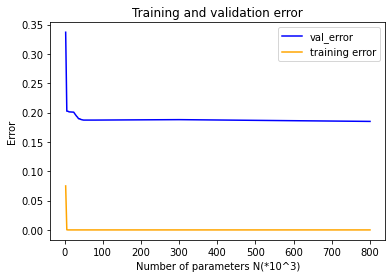

In [23]:
# For networks smaller than the interpolation threshold, we decay the step size by 10% after each of 500 epochs
# For these networks, training is stopped after classification error reached zero or 6000 epochs, whichever happens earlier. For networks larger than interpolation threshold, fixed step size is used, and training is stopped after 6000 epochs.
def lr_decay(epoch, lr):
    return lr * 0.9**(epoch//500)
scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay)

# For networks smaller than the interpolation threshold, training is stopped after classification error reached zero or 6000 epochs,
class CustomCallback_epoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      if logs["accuracy"]==1:
        self.model.stop_training = True
        print('STOPPING EARLY AFTER INTERPOLATING AT EPOCH %d' %epoch)
        print('INTERPOLATION THRESHOLD REACHED')

history_logs = []
saved_weights = []

num_parameters = [i*1000 for i in [3, 6, 9, 12, 24, 28, 32, 34, 36, 38, 40, 42, 46, 50, 80, 150, 300, 800]]
hidden_sizes = [(N-10)//795 for N in num_parameters]
for N in num_parameters:
  print('='*80)
  print('Number of parameters = %d, %d hidden layer neurons' %(N, (N-10)//795)) 
  print('='*80)

  # P = (d+1)·H+(H+1)·K = 785H+10H+10 = 795H+10 --> H = (P-10)/795
  num_nodes = (N-10)//795
  # The remaining weights are initialized with normally distributed random numbers (mean 0 and variance 0.01). The smallest network is initialized using standard Glorotuniform distribution [19].
  normal_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01**0.5)
  glorot_initializer = tf.keras.initializers.GlorotUniform()  
  # if this is the first model (smallest network) use standard Glorotuniform, otherwise use random normal
  initializer = normal_initializer if saved_weights else glorot_initializer

  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(num_nodes, activation='relu', kernel_initializer=initializer, bias_initializer=initializer),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=initializer, bias_initializer=initializer)
  ])

  # paper used SGD with standard momentum (parameter value 0.95)
  opt = tf.keras.optimizers.SGD(momentum=0.95)

  model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  # print(model.weights[0].shape)
  # print(model.weights[1].shape)
  # # print(model.weights[1])
  # print(model.weights[2].shape)
  # # print(model.weights[2])
  # print(model.weights[3].shape)
  # # print(model.weights[3])

  # from paper: To train a larger network with H2 > H1 hidden units, we initialize the first H1 hidden units of the larger network to the weights learned in the smaller network.  
  # equivalently, here we expand saved weight with H1 units from prev model with randomly initialized weight for the new hidden units from the new model, then re-assign the combined weights to the new model
  if saved_weights: 
    prev_weights = saved_weights[-1]
    tf.compat.v1.assign(model.weights[0], tf.concat((prev_weights[0], model.weights[0][:, prev_weights[0].shape[1]:]), axis=1))
    tf.compat.v1.assign(model.weights[1], tf.concat((prev_weights[1], model.weights[1][prev_weights[1].shape[0]:]), axis=0))
    tf.compat.v1.assign(model.weights[2], tf.concat((prev_weights[2], model.weights[2][prev_weights[2].shape[0]:]), axis=0))
    tf.compat.v1.assign(model.weights[3], prev_weights[3])

# For networks smaller than the interpolation threshold, we decay the step size by 10% after each of 500 epochs,
# For these networks, training is stopped after classification error reached zero or 6000 epochs, whichever happens earlier. For networks larger than interpolation threshold, fixed step size is used, and training is stopped after 6000 epochs.

  interpolated = history_logs and max([h[1].history['accuracy'] for h in history_logs])[0] == 1.0
  # interpolated = N >= 40000
  if not interpolated:
    history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=0, callbacks=[CustomCallback_epoch(), scheduler])
  else:
    history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=0)
  
  saved_weights.append(model.weights)

  history_logs.append((N, history))
  print(tf.math.confusion_matrix(y_test, tf.argmax(model.predict(x_test), axis=1)))
  model.summary()
  print('max training accuracy', max(history.history['accuracy']))
  print('min training loss', min(history.history['loss']))
  print('max validation accuracy', max(history.history['val_accuracy']))
  print('min validation loss', min(history.history['val_loss']))
  print()
  print('last training accuracy', history.history['accuracy'][-1])
  print('last training loss', history.history['loss'][-1])
  print('last validation accuracy', history.history['val_accuracy'][-1])
  print('last validation loss', history.history['val_loss'][-1])
  
# plot errors over number of parameters
plt.title('Training and validation error')
plt.plot([i[0]//1000 for i in history_logs], [1-i[1].history['val_accuracy'][-1] for i in history_logs], color='blue', label='val_error')
plt.plot([i[0]//1000 for i in history_logs], [1-i[1].history['accuracy'][-1] for i in history_logs], color='orange', label='training error')
plt.xlabel('Number of parameters N(*10^3)')
plt.ylabel('Error')
plt.legend()

In [ ]:
# full MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# For networks smaller than the interpolation threshold, we decay the step size by 10% after each of 500 epochs
# For these networks, training is stopped after classification error reached zero or 6000 epochs, whichever happens earlier. For networks larger than interpolation threshold, fixed step size is used, and training is stopped after 6000 epochs.
def lr_decay(epoch, lr):
    return lr * 0.9**(epoch//500)
scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay)

# For networks smaller than the interpolation threshold, training is stopped after classification error reached zero or 6000 epochs,
class CustomCallback_epoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      if logs["accuracy"]==1:
        self.model.stop_training = True
        print('STOPPING EARLY AFTER INTERPOLATING AT EPOCH %d' %epoch)
        print('INTERPOLATION THRESHOLD REACHED')

history_logs = []
saved_weights = []

num_parameters = [i*1000 for i in [3, 6, 9, 12, 24, 28, 32, 34, 36, 38, 40, 42, 46, 50, 80, 150, 300, 800]]
hidden_sizes = [(N-10)//795 for N in num_parameters]
for N in num_parameters:
  print('='*80)
  print('Number of parameters = %d, %d hidden layer neurons' %(N, (N-10)//795)) 
  print('='*80)

  # P = (d+1)·H+(H+1)·K = 785H+10H+10 = 795H+10 --> H = (P-10)/795
  num_nodes = (N-10)//795
  # The remaining weights are initialized with normally distributed random numbers (mean 0 and variance 0.01). The smallest network is initialized using standard Glorotuniform distribution [19].
  normal_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01**0.5)
  glorot_initializer = tf.keras.initializers.GlorotUniform()  
  # if this is the first model (smallest network) use standard Glorotuniform, otherwise use random normal
  initializer = normal_initializer if saved_weights else glorot_initializer

  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(num_nodes, activation='relu', kernel_initializer=initializer, bias_initializer=initializer),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=initializer, bias_initializer=initializer)
  ])

  # paper used SGD with standard momentum (parameter value 0.95)
  opt = tf.keras.optimizers.SGD(momentum=0.95)

  model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  # print(model.weights[0].shape)
  # print(model.weights[1].shape)
  # # print(model.weights[1])
  # print(model.weights[2].shape)
  # # print(model.weights[2])
  # print(model.weights[3].shape)
  # # print(model.weights[3])

  # from paper: To train a larger network with H2 > H1 hidden units, we initialize the first H1 hidden units of the larger network to the weights learned in the smaller network.  
  # equivalently, here we expand saved weight with H1 units from prev model with randomly initialized weight for the new hidden units from the new model, then re-assign the combined weights to the new model
  if saved_weights: 
    prev_weights = saved_weights[-1]
    tf.compat.v1.assign(model.weights[0], tf.concat((prev_weights[0], model.weights[0][:, prev_weights[0].shape[1]:]), axis=1))
    tf.compat.v1.assign(model.weights[1], tf.concat((prev_weights[1], model.weights[1][prev_weights[1].shape[0]:]), axis=0))
    tf.compat.v1.assign(model.weights[2], tf.concat((prev_weights[2], model.weights[2][prev_weights[2].shape[0]:]), axis=0))
    tf.compat.v1.assign(model.weights[3], prev_weights[3])

# For networks smaller than the interpolation threshold, we decay the step size by 10% after each of 500 epochs,
# For these networks, training is stopped after classification error reached zero or 6000 epochs, whichever happens earlier. For networks larger than interpolation threshold, fixed step size is used, and training is stopped after 6000 epochs.

  interpolated = history_logs and max([h[1].history['accuracy'] for h in history_logs])[0] == 1.0
  # interpolated = N >= 40000
  if not interpolated:
    history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=0, callbacks=[CustomCallback_epoch(), scheduler])
  else:
    history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), verbose=0)
  
  saved_weights.append(model.weights)

  history_logs.append((N, history))
  print(tf.math.confusion_matrix(y_test, tf.argmax(model.predict(x_test), axis=1)))
  model.summary()
  print('max training accuracy', max(history.history['accuracy']))
  print('min training loss', min(history.history['loss']))
  print('max validation accuracy', max(history.history['val_accuracy']))
  print('min validation loss', min(history.history['val_loss']))
  print()
  print('last training accuracy', history.history['accuracy'][-1])
  print('last training loss', history.history['loss'][-1])
  print('last validation accuracy', history.history['val_accuracy'][-1])
  print('last validation loss', history.history['val_loss'][-1])
  
# plot errors over number of parameters
plt.title('Training and validation error')
plt.plot([i[0]//1000 for i in history_logs], [1-i[1].history['val_accuracy'][-1] for i in history_logs], color='blue', label='val_error')
plt.plot([i[0]//1000 for i in history_logs], [1-i[1].history['accuracy'][-1] for i in history_logs], color='orange', label='training error')
plt.xlabel('Number of parameters N(*10^3)')
plt.ylabel('Error')
plt.legend()

11493376/11490434 [==============================] - 0s 0us/step
Number of parameters = 3000, 3 hidden layer neurons
tf.Tensor(
[[ 899    0    1   12    2   57    6    1    2    0]
 [   0 1078   15    5    1    2    1    0   31    2]
 [   6   17  832   86    5   10   25    1   47    3]
 [   5    7   69  802    1   41    2   45   33    5]
 [   0    2    2    0  843    5   14    3   16   97]
 [  54    1   24   63   27  624   26   19   46    8]
 [  23    0   14    0    6   23  875    0   17    0]
 [   5   29    4   37    5    4    0  851    8   85]
 [   5   52   35   38   47   91   36   11  645   14]
 [   4    4    0    7  108   29    2   44    7  804]], shape=(10, 10), dtype=int32)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)              